# Preprocessing
----------------------

This part of the kernel focuses on preprocessing the data

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import random
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

## Cleaning and processing data

In [63]:
DATA_PATH = '/run/media/sphericalkat/archive/datasets/city_temperature/city_temperature.csv'
data = pd.read_csv(DATA_PATH, 
                   dtype={'States': 'string'}, 
                   low_memory=False,
                  )

# Drop columns we won't be using
data.drop(['Region', 'Country', 'State'], inplace=True, axis=1)

# Let's train on one city
input_data = data.loc[data['City'] == 'Chicago']
input_data['Date'] = pd.to_datetime(input_data[['Year', 'Month', 'Day']])
input_data.drop(['Month', 'Day', 'Year'], inplace=True, axis=1)

# Drop outliers
input_data = input_data.loc[(np.abs(stats.zscore(input_data['AvgTemperature'])) < 3)]

input_data.head()

,City,AvgTemperature,Date
1831781,Chicago,23.7,1995-01-01
1831782,Chicago,13.8,1995-01-02
1831783,Chicago,14.1,1995-01-03
1831784,Chicago,3.8,1995-01-04
1831785,Chicago,5.0,1995-01-05


## Visualization

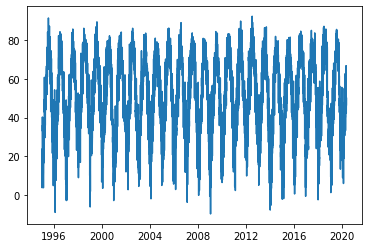

In [65]:
plt.plot(input_data['Date'], input_data['AvgTemperature'])
plt.show()

## Converting series to supervised

In [75]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [76]:
reframed = series_to_supervised(input_data, 1, 1)
reframed.drop(reframed.columns[[0, 2, 3, 5]], inplace=True, axis=1)
reframed.head()

,var2(t-1),var2(t)
1831782,23.7,13.8
1831783,13.8,14.1
1831784,14.1,3.8
1831785,3.8,5.0
1831786,5.0,21.4


## Prepare data for training

In [97]:
# Train-test split
values = reframed.values
train, test = train_test_split(values)

# Split into input and output
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train)
y_train = scaler2.fit_transform(y_train)

test_X = scaler1.transform(X_test)
test_y = scaler2.transform(y_test.reshape(-1, 1))


# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ValueError: Expected 2D array, got 1D array instead:
array=[69.9 56.3 67.7 ... 35.8 76.5 79.7].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.